# Imports

In [1]:
import numpy as np
np.random.seed(0)

import longitudinal_tomography.tomography.tomography as tmo
from longitudinal_tomography.tracking import particles, machine

import longitudinal_tomography.utils.tomo_input as tomoin
import longitudinal_tomography.utils.tomo_output as tomoout
from longitudinal_tomography.tracking import tracking

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [3]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, ThermalDistribution
from PyHEADTAIL.trackers.rf_bucket import RFBucket

/home/oeftiger/anaconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')



PyHEADTAIL v1.16.0


In [4]:
from scipy.constants import m_p, e, c

In [5]:
voltage = 24e3
harmonic = 8
circumference = 100 * 2 * np.pi

gamma = 2.5
beta = np.sqrt(1 - gamma**-2)

alpha_c = 0.027
eta = alpha_c - gamma**-2

In [6]:
rfb = RFBucket(circumference, gamma, m_p, e, [alpha_c], 0., [harmonic], [voltage], [np.pi])

sigma_z = 80e-9 * beta * c / 4. # in [m]

In [7]:
rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 12.378373605203064m.
... distance to target bunch length: -5.4650e+00
... distance to target bunch length: 6.5416e+00
... distance to target bunch length: 5.0576e+00
... distance to target bunch length: 8.1334e-01
... distance to target bunch length: -2.6179e-01
... distance to target bunch length: -4.3733e-03
... distance to target bunch length: 7.3369e-06
... distance to target bunch length: -2.3468e-05
--> Bunch length: 5.4952938631392385
--> Emittance: 0.27882345475015563


In [8]:
def plot_mp(z, dp, rfb=rfb):
    dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
    zz = np.linspace(rfb.z_left, rfb.z_right, num=1000)
    Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
    H = rfb.hamiltonian(Z, DP)
    plt.contour(Z, DP, H, 20, cmap=plt.get_cmap('coolwarm_r'))
    # plt.scatter(z, dp, alpha=0.6)
    my_cmap = plt.get_cmap('hot_r').copy()
    my_cmap.set_under('w',1)
    plt.hist2d(z, dp, bins=40, cmap=my_cmap)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlim(rfb.z_left, rfb.z_right)
    plt.ylim(-dpmax*1.1, dpmax*1.1)
    plt.colorbar().set_label('# macro-particles', fontsize=20)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)
    plt.title('macro-particle generation', fontsize=20)
    return zz, Z, DP

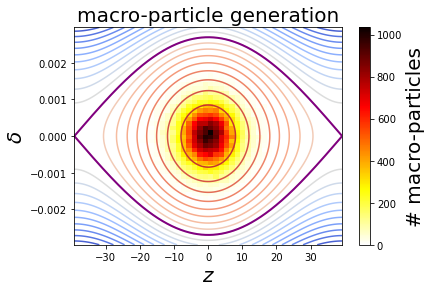

In [9]:
plot_mp(z, dp);

In [10]:
nbins = 100
z_bins = np.linspace(*rfb.interval, num=nbins-1)

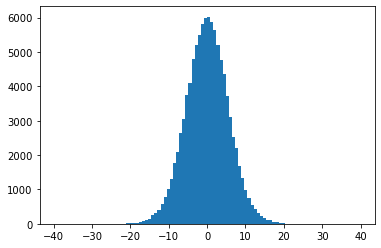

In [11]:
plt.hist(z, bins=z_bins);

In [12]:
1 / rfb.Q_s

696.2858111400514

In [13]:
dtbin = (z_bins[1] - z_bins[0]) / (beta * c)
dtbin

2.9459463503917286e-09

In [14]:
def track(z, dp):
    # half drift
    z = z - eta * dp * circumference / 2
    # rf kick
    amplitude = rfb.charge * voltage / (beta * c * rfb.p0)
    phi = harmonic * (2 * np.pi * z / circumference) + rfb.phi_offset_list[0]
    dp += amplitude * np.sin(phi)
    # half drift
    z = z - eta * dp * circumference / 2
    return z, dp

In [15]:
dp *= 0.8

In [16]:
record_every_nturns = 10

In [17]:
raw_data = [np.histogram(z, bins=z_bins)[0]]

for i in tqdm(range(1, 700 + 1)):
    z, dp = track(z, dp)
    if not i % record_every_nturns:
        raw_data += [np.histogram(z, bins=z_bins)[0]]

  0%|          | 0/700 [00:00<?, ?it/s]

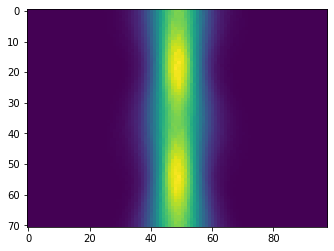

In [18]:
plt.imshow(raw_data)

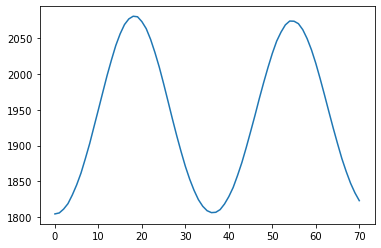

In [19]:
plt.plot(np.std(raw_data, axis=1))

In [20]:
frame_input_args = {
    'raw_data_path':    './',
    'framecount':       len(raw_data), # Number of frames in input data
    'skip_frames':      0, # Number of frames to ignore
    'framelength':      len(raw_data[0]), # Number of bins in each frame
    'dtbin':            dtbin, # Width (in s) of each frame bin
    'skip_bins_start':  0, # Number of frame bins before the lower profile bound to ignore
    'skip_bins_end':    0, # Number of frame bins after the upper profile bound to ignore
    'rebin':            1, #Number of frame bins to rebin into one profile bin
}

In [21]:
Ekin = 1.4e9
p0c = np.sqrt(Ekin**2 + 2*Ekin*m_p/e * c**2)
brho = p0c / c
brho / 70.08

0.10194295908040983

In [22]:
machine_args = {
    'output_dir':           '/tmp/', # Directory in which to write all output
    'dtbin':                dtbin, # Width (in s) of each frame bin
    'dturns':               record_every_nturns, # Number of machine turns between frames
    'synch_part_x':         frame_input_args['framelength']/2, # Time (in frame bins) from the lower profile bound to the synchronous phase (if <0, a fit is performed) in the "bunch reference" frame
    'demax':                -1e6,              # noqa - Max energy (in eV) of reconstructed phase space (if >0)
    'filmstart':            0, # Number of the first profile at which to reconstruct
    'filmstop':             1, # Number of the last profile at which to reconstruct
    'filmstep':             1, # Step between reconstructions
    'niter':                30, # Number of iterations for each reconstruction
    'snpt':                 4, # Square root of the number of test particles to track per cell
    'full_pp_flag':         False, # Flag to extend the region in phase space of map elements (if =1)
    'beam_ref_frame':       0, # Reference frame for bunch parameters (synchronous phase, baseline, integral)
    'machine_ref_frame':    0, # Reference frame for machine parameters (RF voltages, B-field)
    'vrf1':                 voltage, # Peak RF voltage (in V) of principal RF system
    'vrf1dot':              0.0, # and its time derivative (in V/s)
    'vrf2':                 0.0, # Peak RF voltage (in V) of higher-harmonic RF system
    'vrf2dot':              0.0, # and its time derivative (in V/s)
    'h_num':                harmonic, # Harmonic number of principal RF system
    'h_ratio':              2.0, # Ratio of harmonics between RF systems
    'phi12':                0, # Phase difference (in radians of the principal harmonic) between RF systems
    'b0':                   0.1, # Dipole magnetic field (in T) -- up to 1.8T
    'bdot':                 0.0, # and its time derivative (in T/s) -- up to 10T/s
    'mean_orbit_rad':       circumference / (2 * np.pi), # Machine radius (in m)
    'bending_rad':          70.08, # Bending radius (in m)
    'trans_gamma':          alpha_c**-0.5, # Gamma transition
    'rest_energy':          m_p * c**2 / e, # Rest mass (in eV/c**2) of accelerated particle
    'charge':               1, # Charge state of accelerated particle
    'self_field_flag':      False, # Flag to include self-fields in the tracking (if =1)
    'g_coupling':           0.0, # Geometrical coupling coefficient
    'zwall_over_n':         0.0, # Reactive impedance (in Ohms per mode number) over a machine turn
    'pickup_sensitivity':   1, # Effective pick-up sensitivity (in digitizer units per instantaneous Amp)
    'nprofiles':            frame_input_args['framecount'],
    'nbins':                frame_input_args['framelength'],
    'min_dt':               0.0,
    'max_dt':               dtbin * frame_input_args['framelength'],
}


In [23]:
frames = tomoin.Frames(**frame_input_args)

In [24]:
mach = machine.Machine(**machine_args)

In [25]:
mach.values_at_turns()

In [26]:
measured_waterfall = frames.to_waterfall(np.array(raw_data, dtype=float).flatten())

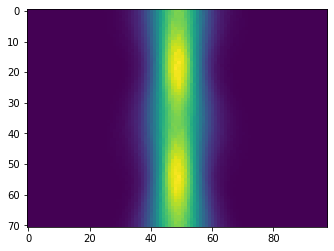

In [27]:
plt.imshow(measured_waterfall)

In [28]:
profiles = tomoin.raw_data_to_profiles(
    measured_waterfall, mach, frames.rebin, frames.sampling_time)
profiles.calc_profilecharge()

In [29]:
if profiles.machine.synch_part_x < 0:
    fit_info = dtreat.fit_synch_part_x(profiles)
    mach.load_fitted_synch_part_x_ftn(fit_info)

In [30]:
reconstr_idx = mach.filmstart

In [31]:
tracker = tracking.Tracking(mach)

In [32]:
xp, yp = tracker.track(reconstr_idx)

In [33]:
# Converting from physical coordinates ([rad], [eV])
# to phase space coordinates.
if not tracker.self_field_flag:
    xp, yp = particles.physical_to_coords(
        xp, yp, mach, tracker.particles.xorigin,
        tracker.particles.dEbin)


In [34]:
xp, yp = particles.ready_for_tomography(xp, yp, mach.nbins)

In [35]:
waterfall = profiles.waterfall

# Short version

In [36]:
# Reconstructing phase space
tomo = tmo.TomographyCpp(waterfall, xp)
weight = tomo.run(niter=mach.niter)

In [37]:
image = tomoout.create_phase_space_image(
    xp, yp, weight, nbins, reconstr_idx)

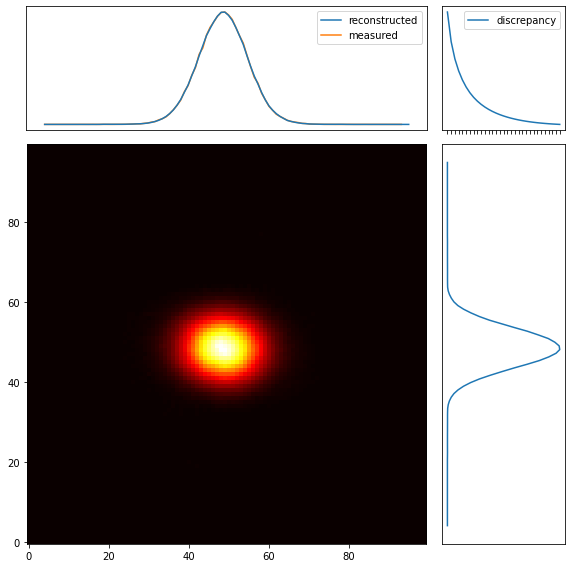

In [38]:
tomoout.show(image, tomo.diff, waterfall[reconstr_idx])

# Detailed version

In [65]:
niterations = 50
nprofs = waterfall.shape[0]
nbins = waterfall.shape[1]
nparts = xp.shape[0]
rec_tframe = 0

In [54]:
flat_profs = waterfall.copy()
flat_profs = flat_profs.clip(0.0)

In [55]:
flat_profs /= np.sum(flat_profs, axis=1)[:, None]
flat_profs = np.ascontiguousarray(flat_profs.flatten()).astype(np.float64)

In [56]:
waterfall /= np.sum(waterfall, axis=1)[:, None]

In [57]:
flat_points = xp.copy()
for i in range(nprofs):
    flat_points[:, i] += nbins * i

In [58]:
# Reconstructing phase space
weight = np.zeros(nparts)
rec_wf = np.zeros(waterfall.shape)

In [59]:
libtomo = tmo.libtomo

In [60]:
# Initial estimation of weight factors using (flattened) measured profiles.
weight = libtomo.back_project(weight, flat_points, flat_profs,
                              nparts, nprofs)
weight = weight.clip(0.0)

In [66]:
diff = []
for i in range(niterations):
    # Projection from phase space to time projections
    rec_wf = libtomo.project(rec_wf, flat_points, weight, nparts,
                             nprofs, nbins)

    # Normalizing reconstructed waterfall
    rec_wf /= np.sum(rec_wf, axis=1)[:, None]

    # Finding difference between measured and reconstructed waterfall
    dwaterfall = waterfall - rec_wf

    # Setting to zero for next round
    rec_wf[:] = 0.0

    # Calculating discrepancy
    diff.append(np.sqrt(np.sum(dwaterfall ** 2) / (nbins * nprofs)))

    # Back projecting using the difference between measured and rec. waterfall
    weight = libtomo.back_project(weight, flat_points, dwaterfall.flatten(),
                                  nparts, nprofs)
    weight = weight.clip(0.0)

    print(f'Iteration: {i:3d}, discrepancy: {diff[-1]:3E}')

Iteration:   0, discrepancy: 1.030654E-03
Iteration:   1, discrepancy: 1.019441E-03
Iteration:   2, discrepancy: 1.009895E-03
Iteration:   3, discrepancy: 1.001737E-03
Iteration:   4, discrepancy: 9.947115E-04
Iteration:   5, discrepancy: 9.886530E-04
Iteration:   6, discrepancy: 9.834089E-04
Iteration:   7, discrepancy: 9.788411E-04
Iteration:   8, discrepancy: 9.748439E-04
Iteration:   9, discrepancy: 9.713297E-04
Iteration:  10, discrepancy: 9.682356E-04
Iteration:  11, discrepancy: 9.654983E-04
Iteration:  12, discrepancy: 9.630716E-04
Iteration:  13, discrepancy: 9.609199E-04
Iteration:  14, discrepancy: 9.589951E-04
Iteration:  15, discrepancy: 9.572651E-04
Iteration:  16, discrepancy: 9.557107E-04
Iteration:  17, discrepancy: 9.543143E-04
Iteration:  18, discrepancy: 9.530549E-04
Iteration:  19, discrepancy: 9.519142E-04
Iteration:  20, discrepancy: 9.508797E-04
Iteration:  21, discrepancy: 9.499362E-04
Iteration:  22, discrepancy: 9.490734E-04
Iteration:  23, discrepancy: 9.482

In [67]:
# Finding last discrepancy...
rec_wf = libtomo.project(rec_wf, flat_points, weight, nparts, nprofs, nbins)
rec_wf /= np.sum(rec_wf, axis=1)[:, None]
dwaterfall = waterfall - rec_wf
diff.append(np.sqrt(np.sum(dwaterfall ** 2) / (nbins * nprofs)))
print(f'Iteration: {i + 1:3d}, discrepancy: {diff[-1]:3E}')

Iteration:  50, discrepancy: 9.383820E-04


In [68]:
image = tomoout.create_phase_space_image(
    xp, yp, weight, nbins, rec_tframe)

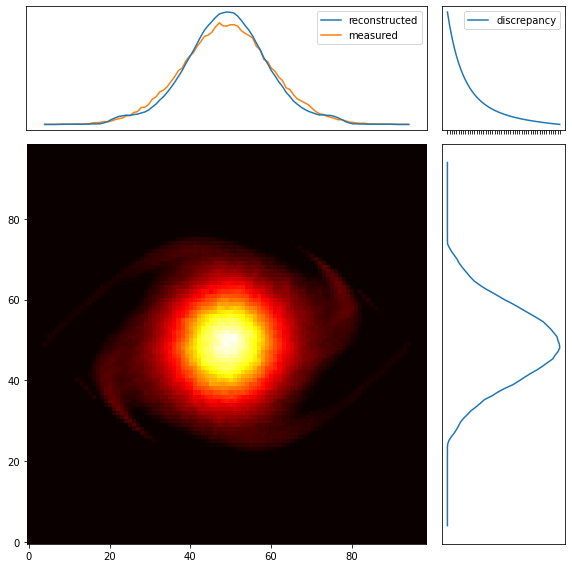

In [69]:
# fig = plt.figure(figsize=(8, 5))

tomoout.show(image, diff, waterfall[rec_tframe]) #, figure=fig)